In [1]:
import os
import sys
import ast
import cv2
import json
import math
import shutil
import random
import pickle
import imageio
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
from pprint import pprint
import matplotlib.pyplot as plt
sys.path.append('./')
sys.path.append('/home/li.yu/code/JupiterCVML/europa/base/src/europa')
from utils import normalize_image, plot_image, plot_images

In [2]:
# load human pose info
# human_pose_csv = '/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/all_human_pose_0209_v1.csv'
# human_pose_csv = '/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/all_human_pose_0219_v2.csv'
human_pose_csv = '/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/all_human_pose_0222_v3.csv'
hp_df = pd.read_csv(human_pose_csv, converters={"properties__json": ast.literal_eval})
hp_df.drop('id', axis=1, inplace=True)
hp_df.rename({'image': 'id'}, axis=1, inplace=True)
# hp_df.drop_duplicates(subset='id', inplace=True)
print(hp_df.shape)

# combine labels
g = hp_df.groupby('id')
data = {'id':[], 'properties__json':[]}
for name, dfg in g:
    data['id'].append(name)
    if len(dfg) == 1:
        data['properties__json'].append(dfg.iloc[0].properties__json)
    else:
        ls = dfg.properties__json.to_list()
        data['properties__json'].append([d for l in ls for d in l])
hp_df2 = pd.DataFrame(data=data)
print(hp_df2.shape)

hp_df2.head(2)

(150731, 2)
(139800, 2)


,id,properties__json
0,5df9238180a73f861bcc1d3b,"[{'featureId': 'cls9v9rs9001u356nr555d3qz', 's..."
1,5df923b980a73f861bcd0f07,"[{'featureId': 'cls9txj8x0016356nv2nq7f25', 's..."


In [3]:
def get_human_pose(row):
    for label in row.properties__json:
        if label['title'] == 'Pose':
            row['Pose'] = label['answer']['title']
        if label['title'] == 'Human Clothing':
            row['Human Clothing'] = label['answer']['title']
        if label['title'] == 'Human Occlusion':
            row['Human Occlusion'] = label['answer']['title']
    return row

def get_camera_pod(df, halo_data=True):
    if halo_data:
        from dl.utils.config_halo import HALO_CAMERAS_TO_PODS
        df['camera_pod'] = df['camera_location'].apply(lambda s: HALO_CAMERAS_TO_PODS[s])
    else:
        REV1_CAMERAS_TO_PODS = {'side-left-left': 'rear', 'side-right-left': 'rear', 'front-left-left': 'front',
                                'front-center-left': 'front', 'front-right-left': 'front', 'rear-left': 'rear',
                                'front-center-right': 'front', 'side-left-right': 'rear'}
        df['camera_pod'] = df['camera_location'].apply(lambda s: REV1_CAMERAS_TO_PODS[s])
    return df

def prepare_df(root_dir, dataset, csv, hp_df, dist_csv_path, halo_data=True):
    print(f'loading dataset {dataset}')
    csv = os.path.join(root_dir, dataset, csv)
    converters = {"label_map": ast.literal_eval, "label_counts": ast.literal_eval}
    df = pd.read_csv(csv, converters=converters)
    print('csv as loaded', df.shape)

    # drop duplicates on id
    df.drop_duplicates(subset='unique_id', inplace=True)
    df = get_camera_pod(df, halo_data)
    print('drop duplicated unique_id', df.shape)

    # load depth/distance info
    dist_df = pd.read_csv(dist_csv_path).drop_duplicates(subset='unique_id')
    final_df = df.merge(dist_df, on='unique_id')
    print('merge with dist df and get pod info', final_df.shape)

    # remove non-human images
    final_df = final_df[final_df['is_human_present'] == 'Yes']
    print('drop non-human image', final_df.shape)

    # merge human pose df
    final_df2 = final_df.merge(hp_df, on='id', how='inner')
    print('merge with human pose info', final_df2.shape)

    # retrieve human pose info
    final_df2['Pose'] = ''
    final_df2['Human Clothing'] = ''
    final_df2['Human Occlusion'] = 'non_occluded'
    final_df2 = final_df2.apply(lambda r: get_human_pose(r), axis=1)
    print('retrieve human pose info', final_df2.shape)
    print()

    return final_df, final_df2

In [4]:
# # Halo train
# root_dir = '/data2/jupiter/datasets/'
# dataset = 'halo_rgb_stereo_train_v6_2'
# csv = 'master_annotations_dedup.csv'
# dist_csv_path = '/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/train_v6_2_full_res.csv'
# halo_data = True
# halo_train_full_df_ori, halo_train_hp_df_ori = prepare_df(root_dir, dataset, csv, hp_df, dist_csv_path, halo_data=halo_data)

# # Rev1 train
# root_dir = '/data2/jupiter/datasets/'
# dataset = 'Jupiter_train_v6_2'
# csv = 'master_annotations.csv'
# dist_csv_path = '/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/rev1_train_v6_2.csv'
# halo_data = False
# rev1_train_full_df_ori, rev1_train_hp_df_ori = prepare_df(root_dir, dataset, csv, hp_df, dist_csv_path, halo_data=halo_data)

# Halo test
root_dir = '/data2/jupiter/datasets/'
# dataset = 'human_annotations_interim_halo_v6_2_mainline'
# dataset = 'human_annotations_interim_halo_v6_2_3_mainline'
dataset = 'halo_humans_on_path_test_v6_2_3_mainline'
csv = 'master_annotations.csv'
dist_csv_path = '/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/test_v6_2_3.csv'
halo_data = True
halo_test_full_df_ori, halo_test_hp_df_ori = prepare_df(root_dir, dataset, csv, hp_df2, dist_csv_path, halo_data=halo_data)

# Rev1 test
root_dir = '/data/jupiter/datasets/'
dataset = 'humans_on_path_test_set_2023_v15_anno'
csv = 'master_annotations.csv'
dist_csv_path = '/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/rev1_test_humanv15.csv'
halo_data = False
rev1_test_full_df_ori, rev1_test_hp_df_ori = prepare_df(root_dir, dataset, csv, hp_df2, dist_csv_path, halo_data=halo_data)

loading dataset halo_humans_on_path_test_v6_2_3_mainline


<ipython-input-4-f062da62c548>:25: DtypeWarning: Columns (23,157,158,159,160,161,163,164,166,167,168,169,170,171,172,173,174,291,313,326,343,345,346,347,348,349,350,354,377,386) have mixed types.Specify dtype option on import or set low_memory=False.
  halo_test_full_df_ori, halo_test_hp_df_ori = prepare_df(root_dir, dataset, csv, hp_df2, dist_csv_path, halo_data=halo_data)


csv as loaded (16181, 472)
drop duplicated unique_id (15113, 473)
merge with dist df and get pod info (15113, 492)
drop non-human image (15071, 492)
merge with human pose info (14694, 493)
retrieve human pose info (14694, 496)

loading dataset humans_on_path_test_set_2023_v15_anno


<ipython-input-4-f062da62c548>:33: DtypeWarning: Columns (92,93,157,210) have mixed types.Specify dtype option on import or set low_memory=False.
  rev1_test_full_df_ori, rev1_test_hp_df_ori = prepare_df(root_dir, dataset, csv, hp_df2, dist_csv_path, halo_data=halo_data)


csv as loaded (19846, 234)
drop duplicated unique_id (19846, 235)
merge with dist df and get pod info (19846, 254)
drop non-human image (19833, 254)
merge with human pose info (16164, 255)
retrieve human pose info (16164, 258)



In [5]:
halo_train_hp_df = halo_test_hp_df_ori
halo_test_hp_df = rev1_test_hp_df_ori
print(halo_train_hp_df.shape, halo_test_hp_df.shape)

(14694, 496) (16164, 258)


In [7]:
all_pose = list(set(halo_train_hp_df.Pose.unique()) | set(halo_test_hp_df.Pose.unique()))
all_clothing = list(set(halo_train_hp_df['Human Clothing'].unique()) | set(halo_test_hp_df['Human Clothing'].unique()))
all_pose.sort()
all_clothing.sort()
print(all_pose, all_clothing)

['', 'bent_over', 'carrying_object', 'crouching_kneeling_sitting_squatting', 'greeting_embrace', 'holding_child', 'leaning', 'lifting_object', 'lying_down', 'pointing', 'pushing_object', 'reading_phone_book_object', 'running_walking', 'standing_hands_down'] ['', 'bright_clothing', 'camo_clothing', 'dark_clothing', 'mixed_clothing']


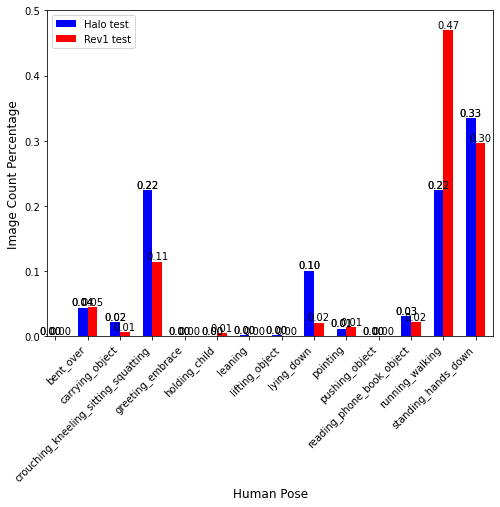

In [18]:
halo_train_g = halo_train_hp_df[['id', 'Pose']].groupby('Pose').count() / len(halo_train_hp_df)
# halo_train_g.rename(columns={"id": "Halo train"}, inplace=True)
# halo_train_g.rename(columns={"id": "Rev1 train"}, inplace=True)
halo_train_g.rename(columns={"id": "Halo test"}, inplace=True)
halo_test_g = halo_test_hp_df[['id', 'Pose']].groupby('Pose').count() / len(halo_test_hp_df)
# halo_test_g.rename(columns={"id": "Halo test"}, inplace=True)
# halo_test_g.rename(columns={"id": "Rev1 train"}, inplace=True)
halo_test_g.rename(columns={"id": "Rev1 test"}, inplace=True)

fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
ax1 = halo_train_g.plot.bar(rot=0, color='blue', ax=ax, position=1.0, width=0.3, sharex=True, sharey=True)
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.2f')
ax2 = halo_test_g.plot.bar(rot=0, color='red', ax=ax, position=0.0, width=0.3, sharex=True, sharey=True)
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.2f')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.0, 0.5)
plt.xlabel("Human Pose", fontsize=12)
plt.ylabel("Image Count Percentage", fontsize=12)
plt.show()

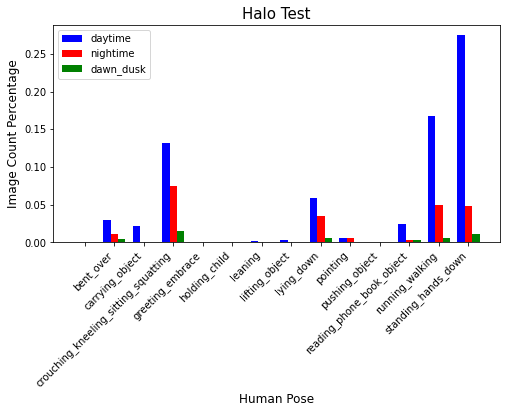

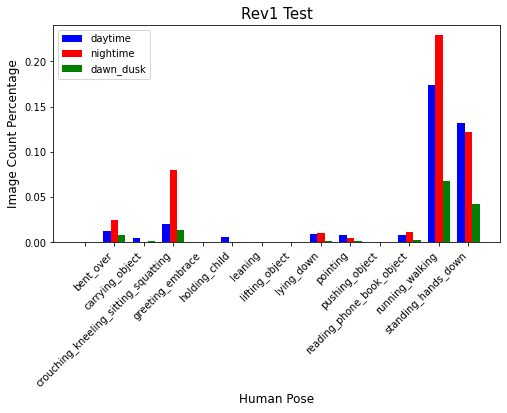

In [20]:
# human pose per operation time
def human_pose_dist_vs_op_time(halo_train_hp_df, title):
    halo_train_g = halo_train_hp_df[['id', 'Pose', 'operation_time']].groupby(['operation_time', 'Pose']).size().reset_index(name='counts')

    N = len(all_pose)
    ind = np.arange(N)
    width = 0.25

    fig = plt.figure(1, figsize=(8, 4))
    op_times = ['daytime', 'nightime', 'dawn_dusk']
    bars, colors = [], ['b', 'r', 'g']
    for i, (op_time, c) in enumerate(zip(op_times, colors)):
        sub_df = halo_train_g[halo_train_g.operation_time == op_time]
        counts_d = dict(zip(sub_df['Pose'], sub_df['counts']))
        counts = [counts_d.get(p, 0) / len(halo_train_hp_df) for p in all_pose]
        bar = plt.bar(ind+width*i, counts, width, color=c)
        bars.append(bar)
    plt.xlabel('Human Pose', fontsize=12)
    plt.ylabel('Image Count Percentage', fontsize=12)
    plt.title(title, fontsize=15)
    plt.xticks(ind+width, all_pose, rotation=45, ha='right')
    plt.legend(bars, op_times)
    plt.show()

# human_pose_dist_vs_op_time(halo_train_hp_df, "Halo Train")
# human_pose_dist_vs_op_time(halo_train_hp_df, "Rev1 Train")
human_pose_dist_vs_op_time(halo_train_hp_df, "Halo Test")
# human_pose_dist_vs_op_time(halo_test_hp_df, "Halo Test")
# human_pose_dist_vs_op_time(halo_test_hp_df, "Rev1 Train")
human_pose_dist_vs_op_time(halo_test_hp_df, "Rev1 Test")

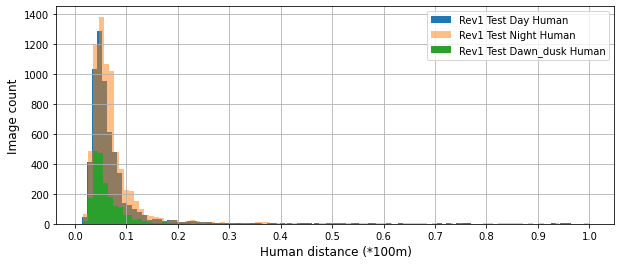

In [26]:
# human pose per distance

# # general
# plt.figure(1, figsize=(10, 6))
# halo_train_hp_df[(halo_train_hp_df['human_90_percentile_depth'] < 1.0)]['human_90_percentile_depth'].hist(bins=100)
# halo_test_hp_df[(halo_test_hp_df['human_90_percentile_depth'] < 1.0)]['human_90_percentile_depth'].hist(bins=100, alpha=0.5)
# # plt.legend(['Halo Train', 'Halo Test'])
# # plt.legend(['Halo Train', 'Rev1 Train'])
# # plt.legend(['Rev1 Train', 'Rev1 Test'])
# plt.legend(['Halo Test', 'Rev1 Test'])

# # lying down vs. standing
# plt.figure(1, figsize=(10, 4))
# # halo_train_hp_df[(halo_train_hp_df['Pose'].isin(['running_walking', 'standing_hands_down'])) & (halo_train_hp_df['human_90_percentile_depth'] < 1.0)]['human_90_percentile_depth'].hist(bins=100)
# # halo_train_hp_df[(halo_train_hp_df['Pose'].isin(['lying_down'])) & (halo_train_hp_df['human_90_percentile_depth'] < 1.0)]['human_90_percentile_depth'].hist(bins=100)
# # # plt.legend(['Halo Train Standing Human', 'Halo Train Lying Down Human'])
# # # plt.legend(['Rev1 Train Standing Human', 'Rev1 Train Lying Down Human'])
# # plt.legend(['Halo Test Standing Human', 'Halo Test Lying Down Human'])
# halo_test_hp_df[(halo_test_hp_df['Pose'].isin(['running_walking', 'standing_hands_down'])) & (halo_test_hp_df['human_90_percentile_depth'] < 1.0)]['human_90_percentile_depth'].hist(bins=100)
# halo_test_hp_df[(halo_test_hp_df['Pose'].isin(['lying_down'])) & (halo_test_hp_df['human_90_percentile_depth'] < 1.0)]['human_90_percentile_depth'].hist(bins=100)
# # plt.legend(['Halo Test Standing Human', 'Halo Test Lying Down Human'])
# # plt.legend(['Rev1 Train Standing Human', 'Rev1 Train Lying Down Human'])
# # plt.legend(['Rev1 Test Standing Human', 'Rev1 Test Lying Down Human'])
# plt.legend(['Rev1 Test Standing Human', 'Rev1 Test Lying Down Human'])

# day vs night
plt.figure(1, figsize=(10, 4))
# halo_train_hp_df[(halo_train_hp_df['operation_time'] == 'daytime') & (halo_train_hp_df['human_90_percentile_depth'] < 1.0)]['human_90_percentile_depth'].hist(bins=100)
# halo_train_hp_df[(halo_train_hp_df['operation_time'] == 'nightime') & (halo_train_hp_df['human_90_percentile_depth'] < 1.0)]['human_90_percentile_depth'].hist(bins=100, alpha=0.5)
# halo_train_hp_df[(halo_train_hp_df['operation_time'] == 'dawn_dusk') & (halo_train_hp_df['human_90_percentile_depth'] < 1.0)]['human_90_percentile_depth'].hist(bins=100)
# # plt.legend(['Halo Train Day Human', 'Halo Train Night Human', 'Halo Train Dawn_dusk Human'])
# # plt.legend(['Rev1 Train Day Human', 'Rev1 Train Night Human', 'Rev1 Train Dawn_dusk Human'])
# plt.legend(['Halo Test Day Human', 'Halo Test Night Human', 'Halo Test Dawn_dusk Human'])
halo_test_hp_df[(halo_test_hp_df['operation_time'] == 'daytime') & (halo_test_hp_df['human_90_percentile_depth'] < 1.0)]['human_90_percentile_depth'].hist(bins=100)
halo_test_hp_df[(halo_test_hp_df['operation_time'] == 'nightime') & (halo_test_hp_df['human_90_percentile_depth'] < 1.0)]['human_90_percentile_depth'].hist(bins=100, alpha=0.5)
halo_test_hp_df[(halo_test_hp_df['operation_time'] == 'dawn_dusk') & (halo_test_hp_df['human_90_percentile_depth'] < 1.0)]['human_90_percentile_depth'].hist(bins=100)
# plt.legend(['Halo Test Day Human', 'Halo Test Night Human', 'Halo Test Dawn_dusk Human'])
# plt.legend(['Rev1 Train Day Human', 'Rev1 Train Night Human', 'Rev1 Train Dawn_dusk Human'])
plt.legend(['Rev1 Test Day Human', 'Rev1 Test Night Human', 'Rev1 Test Dawn_dusk Human'])

plt.xticks([i/10 for i in range(0, 11)])
plt.xlabel('Human distance (*100m)', fontsize=12)
plt.ylabel('Image count', fontsize=12)
plt.show()

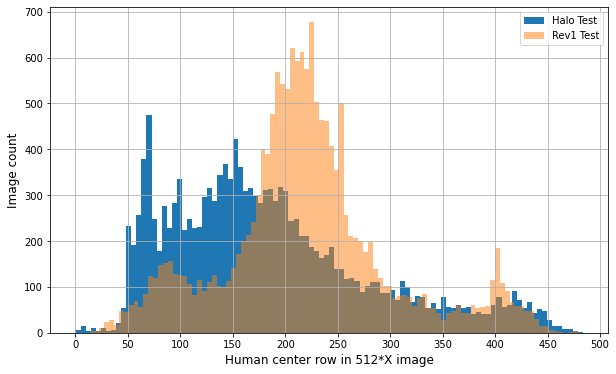

In [27]:
# human location on image
halo_train_hp_df['human_mid_row'] = halo_train_hp_df.apply(lambda r: (r['human_min_row'] + r['human_max_row']) / 2, axis=1)  # / 4 for halo train
halo_test_hp_df['human_mid_row'] = halo_test_hp_df.apply(lambda r: (r['human_min_row'] + r['human_max_row']) / 2, axis=1)
plt.figure(1, figsize=(10, 6))
halo_train_hp_df['human_mid_row'].hist(bins=100)
halo_test_hp_df['human_mid_row'].hist(bins=100, alpha=0.5)
# plt.legend(['Halo Train', 'Rev1 Train'])
plt.legend(['Halo Test', 'Rev1 Test'])
plt.xticks([i for i in range(0, 512, 50)])
plt.xlabel('Human center row in 512*X image', fontsize=12)
plt.ylabel('Image count', fontsize=12)
plt.show()
plt.show()

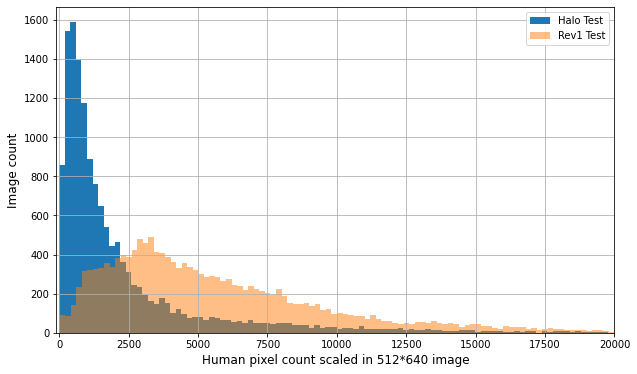

In [28]:
# human pixel counts on image
def scale_pixels(row):
    s = row.image_size
    h, w = s[1:-1].split(', ')
    h, w = int(h), int(w)
    row['human_pixels_scaled'] = row['human_pixels'] / (h * w) * (512 * 640)
    return row

halo_train_hp_df = halo_train_hp_df.apply(lambda r: scale_pixels(r), axis=1)
halo_test_hp_df = halo_test_hp_df.apply(lambda r: scale_pixels(r), axis=1)

plt.figure(1, figsize=(10, 6))
pixel_limit = 20000
halo_train_hp_df[halo_train_hp_df['human_pixels_scaled'] < pixel_limit]['human_pixels_scaled'].hist(bins=100)
halo_test_hp_df[halo_test_hp_df['human_pixels_scaled'] < pixel_limit]['human_pixels_scaled'].hist(bins=100, alpha=0.5)
# plt.legend(['Halo Train', 'Rev1 Train'])
plt.legend(['Halo Test', 'Rev1 Test'])
# plt.xticks([i for i in range(0, 512, 50)])
plt.xlim(-100, pixel_limit)
plt.xlabel('Human pixel count scaled in 512*640 image', fontsize=12)
plt.ylabel('Image count', fontsize=12)
plt.show()
plt.show()

14663 16154


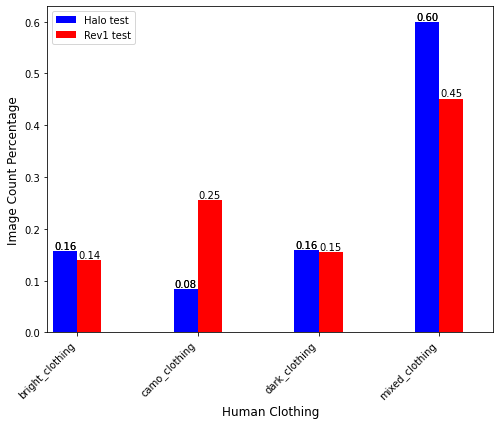

In [32]:
# halo_train_hp_df_clothing = halo_train_hp_df
# halo_test_hp_df_clothing = halo_test_hp_df
halo_train_hp_df_clothing = halo_train_hp_df[halo_train_hp_df['Human Clothing'] != '']
halo_test_hp_df_clothing = halo_test_hp_df[halo_test_hp_df['Human Clothing'] != '']
print(len(halo_train_hp_df_clothing), len(halo_test_hp_df_clothing))

halo_train_g = halo_train_hp_df_clothing[['id', 'Human Clothing']].groupby('Human Clothing').count() / len(halo_train_hp_df_clothing)
# halo_train_g.rename(columns={"id": "Halo train"}, inplace=True)
# halo_train_g.rename(columns={"id": "Rev1 train"}, inplace=True)
halo_train_g.rename(columns={"id": "Halo test"}, inplace=True)
halo_test_g = halo_test_hp_df_clothing[['id', 'Human Clothing']].groupby('Human Clothing').count() / len(halo_test_hp_df_clothing)
# halo_test_g.rename(columns={"id": "Halo test"}, inplace=True)
# halo_test_g.rename(columns={"id": "Rev1 train"}, inplace=True)
halo_test_g.rename(columns={"id": "Rev1 test"}, inplace=True)

fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
ax1 = halo_train_g.plot.bar(rot=0, color='blue', ax=ax, position=1.0, width=0.2, sharex=True, sharey=True)
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.2f')
ax2 = halo_test_g.plot.bar(rot=0, color='red', ax=ax, position=0.0, width=0.2, sharex=True, sharey=True)
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.2f')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Human Clothing", fontsize=12)
plt.ylabel("Image Count Percentage", fontsize=12)
plt.show()

(16154, 259) (10, 259)


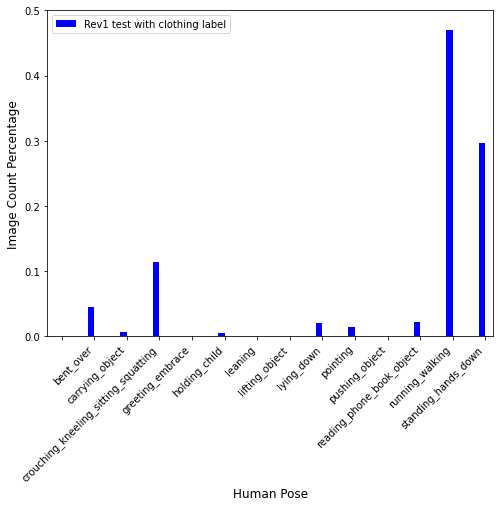

In [33]:
# check missed human clothing labels in rev1 test set
hp_labeled_df = rev1_test_hp_df_ori[rev1_test_hp_df_ori['Human Clothing'] != '']
hp_unlabeled_df = rev1_test_hp_df_ori[rev1_test_hp_df_ori['Human Clothing'] == '']
print(hp_labeled_df.shape, hp_unlabeled_df.shape)

halo_train_g = hp_labeled_df[['id', 'Pose']].groupby('Pose').count() / len(hp_labeled_df)
halo_train_g.rename(columns={"id": "Rev1 test with clothing label"}, inplace=True)
halo_test_g = hp_unlabeled_df[['id', 'Pose']].groupby('Pose').count() / len(hp_unlabeled_df)
halo_test_g.rename(columns={"id": "Rev1 test without clothing label"}, inplace=True)

fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
halo_train_g.plot.bar(rot=0, color='blue', ax=ax, position=1.0, width=0.2, sharex=True, sharey=True)
# halo_test_g.plot.bar(rot=0, color='red', ax=ax, position=0.0, width=0.2, sharex=True, sharey=True)  # number of bars are different
plt.xticks(rotation=45, ha='right')
plt.ylim(0.0, 0.5)
plt.xlabel("Human Pose", fontsize=12)
plt.ylabel("Image Count Percentage", fontsize=12)
plt.show()

In [39]:
halo_train_hp_df.camera_pod.unique(), halo_test_hp_df.camera_pod.unique()

(array(['front', 'right', 'rear', 'left', 'implement'], dtype=object),
 array(['front', 'rear'], dtype=object))

7323 6815


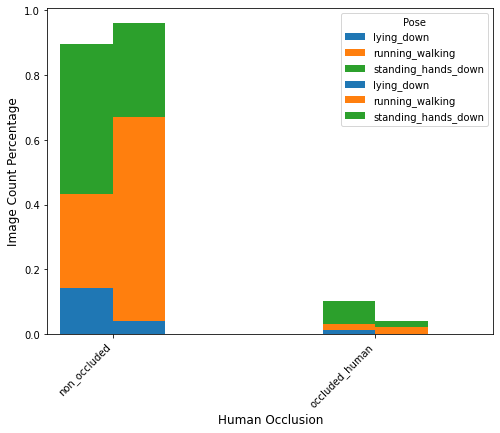

In [58]:
def plot_human_occlusion_dist(halo_train_hp_df, halo_test_hp_df, legend_pad1, legend_pad2):
    halo_train_g = halo_train_hp_df[['id', 'Human Occlusion']].groupby('Human Occlusion').count() / len(halo_train_hp_df)
    # halo_train_g.rename(columns={"id": "Halo train"}, inplace=True)
    # halo_train_g.rename(columns={"id": "Rev1 train"}, inplace=True)
    halo_train_g.rename(columns={"id": f"Halo test{legend_pad1}"}, inplace=True)
    halo_test_g = halo_test_hp_df[['id', 'Human Occlusion']].groupby('Human Occlusion').count() / len(halo_test_hp_df)
    # halo_test_g.rename(columns={"id": "Halo test"}, inplace=True)
    # halo_test_g.rename(columns={"id": "Rev1 train"}, inplace=True)
    halo_test_g.rename(columns={"id": f"Rev1 test{legend_pad2}"}, inplace=True)

    fig = plt.figure(1, figsize=(8, 6))
    ax = fig.add_subplot(111)
    ax1 = halo_train_g.plot.bar(rot=0, color='blue', ax=ax, position=1.0, width=0.2, sharex=True, sharey=True)
    for container in ax1.containers:
        ax1.bar_label(container, fmt='%.2f')
    ax2 = halo_test_g.plot.bar(rot=0, color='red', ax=ax, position=0.0, width=0.2, sharex=True, sharey=True)
    for container in ax2.containers:
        ax2.bar_label(container, fmt='%.2f')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Human Occlusion", fontsize=12)
    plt.ylabel("Image Count Percentage", fontsize=12)
    plt.show()

def plot_human_occlusion_dist_stack(halo_train_hp_df, halo_test_hp_df, legend_pad1='', legend_pad2=''):
    halo_train_g = halo_train_hp_df[['id', 'Human Occlusion', 'Pose']].groupby(['Human Occlusion', 'Pose']).size().unstack() / len(halo_train_hp_df)
    # halo_train_g.rename(columns={"id": "Halo train"}, inplace=True)
    # halo_train_g.rename(columns={"id": "Rev1 train"}, inplace=True)
    halo_train_g.rename(columns={"id": f"Halo test{legend_pad1}"}, inplace=True)
    halo_test_g = halo_test_hp_df[['id', 'Human Occlusion', 'Pose']].groupby(['Human Occlusion', 'Pose']).size().unstack() / len(halo_test_hp_df)
    # halo_test_g.rename(columns={"id": "Halo test"}, inplace=True)
    # halo_test_g.rename(columns={"id": "Rev1 train"}, inplace=True)
    halo_test_g.rename(columns={"id": f"Rev1 test{legend_pad2}"}, inplace=True)

    fig = plt.figure(1, figsize=(8, 6))
    ax = fig.add_subplot(111)
    ax1 = halo_train_g.plot.bar(rot=0, ax=ax, position=1.0, width=0.2, sharex=True, sharey=True, stacked=True)
    # for container in ax1.containers:
    #     ax1.bar_label(container, fmt='%.2f')
    ax2 = halo_test_g.plot.bar(rot=0, ax=ax, position=0.0, width=0.2, sharex=True, sharey=True, stacked=True)
    # for container in ax2.containers:
    #     ax2.bar_label(container, fmt='%.2f')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Human Occlusion", fontsize=12)
    plt.ylabel("Image Count Percentage", fontsize=12)
    plt.show()


# halo_train_hp_df_sub = halo_train_hp_df[halo_train_hp_df['Pose'].isin(['lying_down', 'running_walking', 'standing_hands_down'])]
# halo_test_hp_df_sub = halo_test_hp_df[halo_test_hp_df['Pose'].isin(['lying_down', 'running_walking', 'standing_hands_down'])]
# # plot_human_occlusion_dist(halo_train_hp_df, halo_test_hp_df)
# plot_human_occlusion_dist_stack(halo_train_hp_df_sub, halo_test_hp_df_sub)

halo_train_hp_df_sub = halo_train_hp_df[(halo_train_hp_df['camera_pod'].isin(['front', 'left', 'right'])) & (halo_train_hp_df['Pose'].isin(['lying_down', 'running_walking', 'standing_hands_down']))]
halo_test_hp_df_sub = halo_test_hp_df[(halo_test_hp_df['camera_pod'].isin(['front', 'left', 'right'])) & (halo_test_hp_df['Pose'].isin(['lying_down', 'running_walking', 'standing_hands_down']))]
print(len(halo_train_hp_df_sub), len(halo_test_hp_df_sub))
# plot_human_occlusion_dist(halo_train_hp_df_sub, halo_test_hp_df_sub, ' no rear', ' no rear')
plot_human_occlusion_dist_stack(halo_train_hp_df_sub, halo_test_hp_df_sub, ' no rear', ' no rear')

## Show example images

In [67]:
# sub_df = df[df.id == df.sample(1).iloc[0].id]
# print(sub_df.shape)

# sub_df = halo_train_hp_df[halo_train_hp_df['Human Clothing'] == '']
# print(sub_df.shape)

# sub_df = halo_train_hp_df[halo_train_hp_df['human_90_percentile_depth'] < 0.1]
# print(sub_df.shape)

# root_dir = '/data/jupiter/datasets/'
# dataset = 'humans_on_path_test_set_2023_v15_anno'
# # hp_unlabeled_df = rev1_test_full_df_ori[~rev1_test_full_df_ori.id.isin(rev1_test_hp_df_ori.id)]
# hp_unlabeled_df = rev1_test_hp_df_ori[rev1_test_hp_df_ori['Human Clothing'] == '']
# sub_df = hp_unlabeled_df
# print(sub_df.shape)

root_dir = '/data2/jupiter/datasets/'
dataset = 'halo_humans_on_path_test_v6_2_3_mainline'
# sub_df = halo_train_hp_df_sub[(halo_train_hp_df_sub['Pose'] == 'lying_down') & (halo_train_hp_df_sub['Human Occlusion'] == 'occluded_human')]
sub_df = halo_train_hp_df_sub[(halo_train_hp_df_sub['Human Occlusion'] == 'occluded_human')]
print(sub_df.shape)

(749, 498)


65335cec633f2c568534a786 65335cec633f2c568534a786_T14_T15 T14 occluded_human


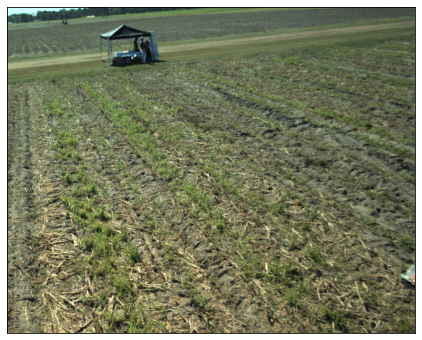

64e5d2c78db25bf27d0182ef 64e5d2c78db25bf27d0182ef_T06_T08 T06 occluded_human


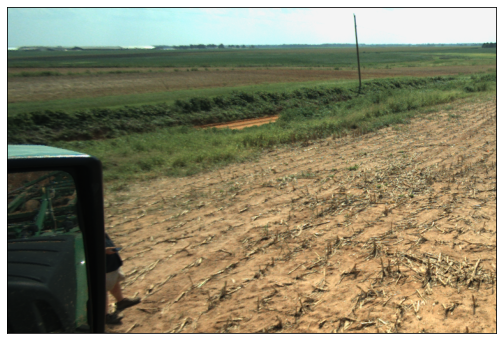

In [70]:
# sub_df = df2[df2.camera_pod == 'implement_pod'].sample(5)
# sub_df = df[(~df.unique_id.isin(negative_ids)) & (df.unique_id.isin(negative_ids_depth30))].sample(2)
# sub_df = df[df.id.isin(cat_df.id)].sample(2)
# sub_df = df[df.bag_date == '12_04_2023'].sample(2)
# sub_df = df[df.unique_id.isin(['64f24c35185004ffd6db442a_T13_T15', '64f103a37f23cbe32a523272_I02_I04'])]
# sub_df = df2.sample(5)
# sub_df = df[df.id.isin(['6441f343fb7e8d35a3da7e9c', '6441f9199b12538afbfcc044'])]
show_image, show_label = True, False
show_debayered_rgb, show_raw_label = False, False

for i, row in sub_df.sample(2).iterrows():
    print(row.id, row.unique_id, row.camera_location, row['Human Occlusion'])
    if show_image:
        data_path = os.path.join(root_dir, dataset, row.stereo_pipeline_npz_save_path)
        img = np.load(data_path)['left']
        img_norm = normalize_image(img, True)
        plot_image(img_norm)

    if show_debayered_rgb:
        image = imageio.imread(os.path.join(root_dir, dataset, row.artifact_debayeredrgb_0_save_path))
        plot_image(image)

    if show_label and 'rectified_label_save_path' in row and isinstance(row.rectified_label_save_path, str):
        label_path = os.path.join(root_dir, dataset, row.rectified_label_save_path)
        label = np.load(label_path)['left']
        labels = np.unique(label)
        label_map =row.label_map
        label_strs = [label_map[str(i)] for i in labels if i != 0]
        print(row.unique_id, labels, label_strs)
        # print(row.id, np.unique(label))
        plot_image(label == 25)

    if show_raw_label:
        label = imageio.imread(os.path.join(root_dir, dataset, row.annotation_pixelwise_0_save_path))
        labels = np.unique(label)
        label_map =row.label_map
        label_strs = [label_map[str(i)] for i in labels if i != 0]
        print(row.unique_id, labels, label_strs)
        plot_image(label == 25)